# 기계학습 - 분류

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

# 한글 깨짐 방지
from matplotlib import font_manager, rc
path = './file/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family = font_name)

## 데이터 로딩

In [3]:
df = pd.read_csv('./data/bikeshare.csv')

## 데이터 구조 확인 및 EDA

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
df.info()

### 데이터 타입 보정

In [ ]:
df.columns

In [7]:
# type별로 컬럼 분류
col_id = []
col_dt = ['datetime']
col_cat = ['season']
col_int = ['weather', 'humidity','casual','registered','count']
col_float = ['temp','atemp','windspeed']
col_bool = ['holiday','workingday']
col_num = col_int + col_float

In [8]:
df['datetime'] = pd.to_datetime(df['datetime'])
df[col_cat]= df[col_cat].astype('str')
df[col_int] = df[col_int].astype('int', errors='ignore')
df[col_float] = df[col_float].astype('float')

In [ ]:
df.describe()

In [ ]:
df.describe(include='object')

### 시각화

<AxesSubplot:xlabel='season', ylabel='casual'>

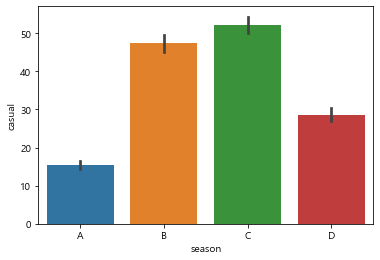

In [9]:
sns.barplot(x='season', y='casual', data=df)

<AxesSubplot:xlabel='count', ylabel='season'>

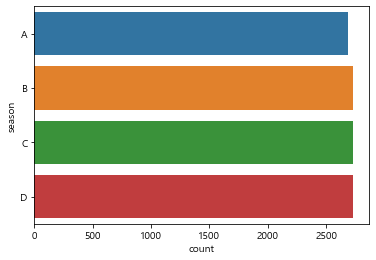

In [10]:
# 범주형(또는 가지수가 많지 않은 연속형) 변수의 데이터별 count
sns.countplot(y = 'season', data = df)

## 전처리

### 중복값

In [ ]:
# 중복값 확인
df[df.duplicated(keep=False)] 

In [ ]:
df.drop_duplicates() # 행 내용이 동일한 경우 제거
df.drop_duplicates(['col1'], keep='last') # col1기준 중복값중 마지막만 남겨둠

### 결측치

In [ ]:
df.isna().sum()

In [ ]:
# na 처리 : dropna(), fillna()
df.dropna() # nan이 하나라도 들어간 행은 삭제
df.dropna(how = 'all') # 데이터가 모두 nan인 행만 삭제 / 초기값:'any'
## Parameters
# axis = 'index' / 'columns'
# subset = ['col1', 'col2', ...] # 적용 대상 컬럼 특정

df.fillna(0) # na를 0으로 채우기

# 평균값, 중앙값으로 대치
df.loc[19,'Leaflets'] = df['Leaflets'].mean() # 평균값으로 
df.loc[19,'Leaflets'] = df['Leaflets'].median # 중앙값으로

### 이상치

<AxesSubplot:xlabel='humidity'>

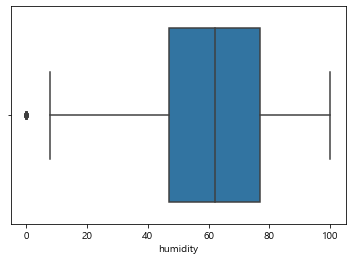

In [12]:
tmp = 'humidity'
sns.boxplot(y = tmp, data = df, orient = 'h')

In [ ]:
# IQR 활용
q1 = df[tmp].quantile(.25)
q3 = df[tmp].quantile(.75)
iqr = q3-q1
min_iqr = q1 - 1.5 * iqr
max_iqr = q3 + 1.5 * iqr
min_from_all = df[tmp].min()
max_from_all = df[tmp].max()
if (min_iqr < min_from_all) :
    min_iqr = min_from_all
if (max_iqr > max_from_all) :
    max_iqr = max_from_all

outlier = df[(df[tmp] < min_iqr ) | (df[tmp] > max_iqr)] # 이상치 조회
outlier_index = outlier.index
print(outlier.shape)
outlier

In [14]:
df.loc[(df[tmp] < min_iqr ),tmp] = min_iqr # 이상치 보정 - 하한치로 보정
df.loc[(df[tmp] > max_iqr ),tmp] = max_iqr # 이상치 보정 - 상한치로 보정

In [ ]:
df = df.drop(outlier_index, axis=0)
df.shape

## 종속변수 분포 확인

<AxesSubplot:ylabel='Frequency'>

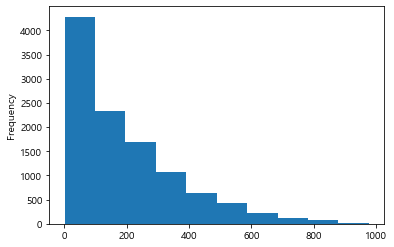

In [20]:
df['count'].plot(kind='hist')

### 왜도가 심할 경우 : log

In [21]:
df['count'] = np.log1p(df['count']) # inverse 는 np.expm1()

<AxesSubplot:ylabel='Frequency'>

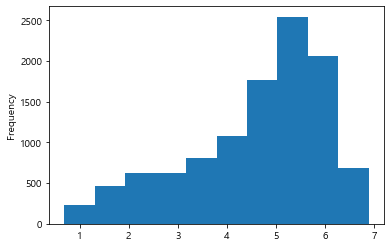

In [22]:
df['count'].plot(kind='hist')

## 변수 더미화

In [23]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices('count ~ season + holiday + workingday+weather+temp+atemp+humidity+windspeed+casual\
+registered', data=df, return_type='dataframe')

## train, test set split

In [25]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.3, random_state=0)

## StandardScaler

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_tr_s = scaler.transform(X_train)
X_te_s = scaler.transform(X_test)

In [27]:
# 컬럼명 다시 붙여주기
X_tr_s = pd.DataFrame(X_tr_s, columns= X_train.columns)
X_te_s = pd.DataFrame(X_te_s, columns= X_test.columns)

## 모델링 및 기초 모델 선정

In [29]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [30]:
models = []
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Huber', HuberRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('KernelRidge', KernelRidge()))
models.append(('MLP', MLPRegressor()))
models.append(('SVR', SVR()))

In [31]:
num_folds = 5
seed = 7

In [ ]:
names = []
results = []

kfold = KFold(n_splits = num_folds, shuffle = True, random_state=seed)

for name, model in models:
    score = cross_val_score(model, X_tr_s, y_train.values.ravel(), cv = kfold)
    names.append(name)
    results.append(score)
    print(name, score.mean().round(3))

In [34]:
names
for i in range(len(names)):
    print(names[i], np.mean(results[i]))

Ridge 0.6869576266225901
Lasso 0.12766777284624842
ElasticNet 0.4066170015225906
Huber 0.6543455278537031
DT 0.9995265287665329
RF 0.9998233076426427
KNN 0.8396057163963567
KernelRidge -9.821102281631966
MLP 0.9939810310301851
SVR 0.9114811341340129


C:\Users\50008313\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\50008313\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


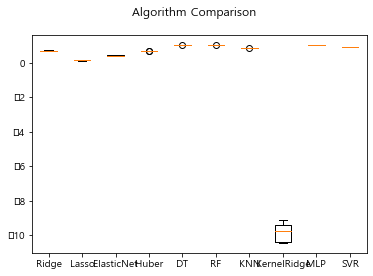

In [35]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 파라미터 튜닝

In [ ]:
model = RandomForestRegressor()

n_estimators_set = [50, 60, 70, 80, 90, 100]
max_features_set = [6, 7, 8, 9, 10]
param_grid = dict(n_estimators = n_estimators_set,
                 max_features = max_features_set)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(X_tr_s, y_train.values.ravel())
print('Best : %f using %s' % (grid_result.best_score_, grid_result.best_params_))

a = grid_result.cv_results_

for i in range(len(a['rank_test_score'])):
    print('%f (%f) with: %r' %(a['mean_test_score'][i], a['std_test_score'][i], a['params'][i]))

In [38]:
fine_tuned_RF = grid_result.best_estimator_
print('best params: ', grid_result.best_params_)
fine_tuned_RF.feature_importances_

best params:  {'max_features': 10, 'n_estimators': 90}


array([0.00000000e+00, 3.43056885e-05, 1.30910325e-05, 1.51482042e-05,
       9.71067687e-06, 6.05942400e-04, 4.31354483e-05, 5.19896282e-04,
       5.01274036e-03, 2.83386573e-04, 9.91056310e-05, 1.51806855e-01,
       8.41556683e-01])

### 변수 중요도 확인

In [40]:
pd.DataFrame({'col':X_tr_s.columns, 'FI':fine_tuned_RF.feature_importances_}).sort_values('FI', ascending=False)

,col,FI
12,registered,0.841557
11,casual,0.151807
8,atemp,0.005013
5,workingday,0.000606
7,temp,0.000520
9,humidity,0.000283
10,windspeed,0.000099
6,weather,0.000043
1,season[T.B],0.000034
3,season[T.D],0.000015


<AxesSubplot:>

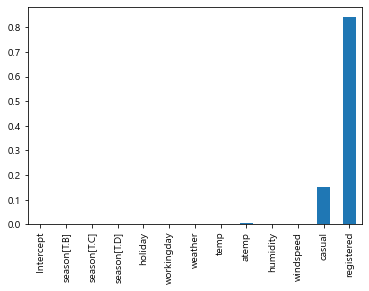

In [42]:
importances = pd.Series(fine_tuned_RF.feature_importances_, index =X_tr_s.columns)
importances.plot(kind='bar')

## Test set 예측 및 성능평가

In [44]:
y_pred = fine_tuned_RF.predict(X_te_s)

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

* **R^2**

In [46]:
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred)) # 종속변수에 log 처리를 했을 경우 expm1을 해줘야함, 아니면 그냥 y_test, y_pred
r2

0.999625707091481

* **MSE**

In [47]:
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred)) 
# 종속변수에 log 처리를 했을 경우 expm1을 해줘야함, 아니면 그냥 y_test, y_pred
mse

12.155115070591316

* **RMSE**

In [48]:
rmse = np.sqrt(mse)
rmse

3.4864186596837903

* **MAE**

In [49]:
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
 # 종속변수에 log 처리를 했을 경우 expm1을 해줘야함, 아니면 그냥 y_test, y_pred
mae

1.3838660714729938

* **MAPE**

In [50]:
def mp(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs(y_test - y_pred)/y_test) * 100
# 평균 절대 백분율 오차(MAPE)는 정확도를 오차의 백분율로 표시합니다.
# MAPE는 백분율이기 때문에 다른 정확도 측도 통계량보다 더 쉽게 이해할 수 있습니다. 
# 예를 들어 MAPE가 5이면 예측 값은 평균 5% 벗어납니다

In [51]:
mape = mp(np.expm1(y_test), np.expm1(y_pred))
 # 종속변수에 log 처리를 했을 경우 expm1을 해줘야함, 아니면 그냥 y_test, y_pred
mape

838.4915215872985